# **이상탐지1: 수업실습용**

## **1. 라이브러리 로드**

In [10]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings(action='ignore') 
%matplotlib inline

# 데이터 전처리 패키지
from sklearn.covariance import EllipticEnvelope
from sklearn.model_selection import train_test_split

# 모델 패키지

from sklearn.datasets import make_blobs
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

# 모델 평가 패키지
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# 시각화 패키지
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

# 마이너스 기호(-) 깨짐 방지
matplotlib.rcParams['axes.unicode_minus'] = False

# # 한글 폰트 사용하기
# plt.rc('font', family='Malgun Gothic')

----------------------------------------------------------------------------------

## **2. 이상치 데이터 셋 임의로 생성**

- make_blobs: 서로 다른 클러스터를 형성하는 데이터를 생성하는 함수
- 입력 매개변수:
    - n_samples: 생성할 데이터 포인트의 수.
    - n_features: 각 데이터 포인트의 특성(차원) 수.
    - centers: 클러스터의 중심 수 또는 중심의 좌표.
    - cluster_std: 각 클러스터의 표준 편차로, 클러스터의 분산 정도를 조절합니다.
    - random_state: 난수 생성 시드로, 동일한 결과를 재현할 수 있도록 합니다.

In [11]:
# 정상 데이터 생성
X_normal, y_normal = make_blobs(n_samples=500, centers=3, n_features=2, cluster_std=1, random_state=42)
df_normal = pd.DataFrame({'feature1': X_normal[:, 0], 'feature2': X_normal[:, 1], 'anomaly_indicator': 0})
# 이상 데이터 생성
X_abnormal, y_abnormal = make_blobs(n_samples=20, centers=2, n_features=2, cluster_std =10, random_state=0)
df_abnormal = pd.DataFrame({'feature1': X_abnormal[:, 0], 'feature2': X_abnormal[:, 1], 'anomaly_indicator': 1})
# 이상 데이터, 정상데이터 combine
df = pd.concat([df_normal, df_abnormal])


In [12]:
# 데이터셋 확인
# defaut로 앞에서 5개의 데이터를 출력
df.head()

,feature1,feature2,anomaly_indicator
0,-5.730354,-7.583286,0
1,1.942992,1.918875,0
2,6.829682,1.164871,0
3,-2.901306,7.550771,0
4,5.841093,1.565094,0


In [13]:
# 데이터셋 크기 확인
df.shape

(520, 3)

In [14]:
# 데이터의 column 값 확인
print(df.keys())

Index(['feature1', 'feature2', 'anomaly_indicator'], dtype='object')


In [15]:
# X 값 확인
X = df[df.columns.difference(['anomaly_indicator'])]
y = df["anomaly_indicator"]
print('X:', X.shape)
X

X: (520, 2)


,feature1,feature2
0,-5.730354,-7.583286
1,1.942992,1.918875
2,6.829682,1.164871
3,-2.901306,7.550771
4,5.841093,1.565094
...,...,...
15,14.358174,12.921462
16,-1.423854,2.461153
17,-15.007434,20.405418
18,15.917061,2.252205


<Axes: xlabel='feature1', ylabel='feature2'>

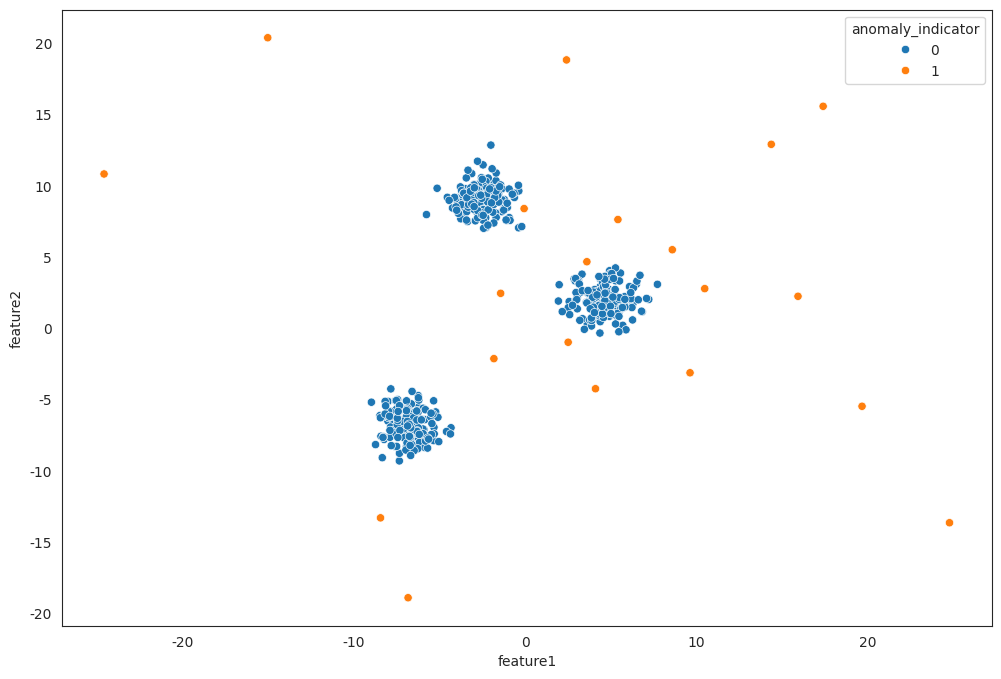

In [16]:
# 데이터 시각화 
plt.figure(figsize=(12, 8))
sns.scatterplot(x='feature1', y='feature2', hue='anomaly_indicator', data=df)

----------------------------------------------------------------------------------

## **3. 탐색적 데이터 분석(EDA)**

### **3-1. 데이터의 변수별 분포 확인**

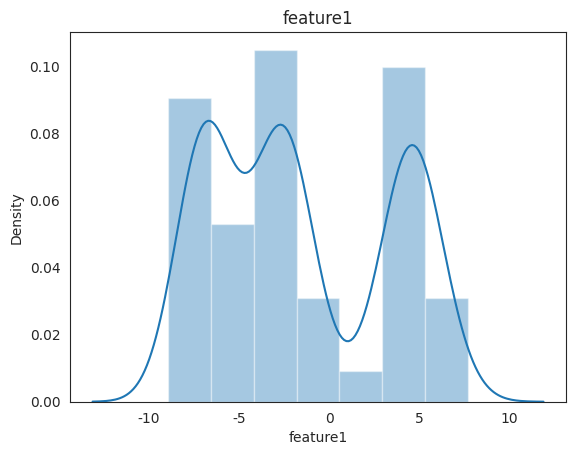

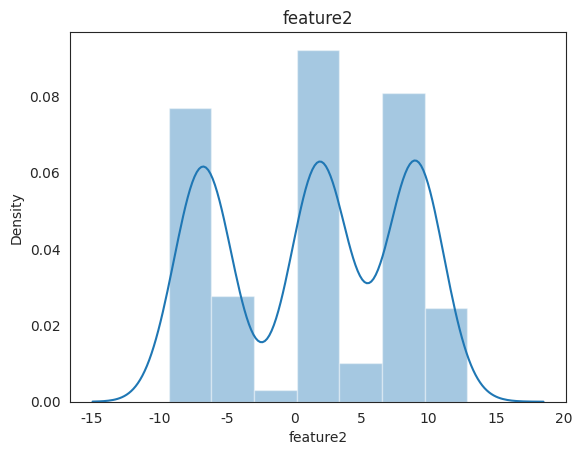

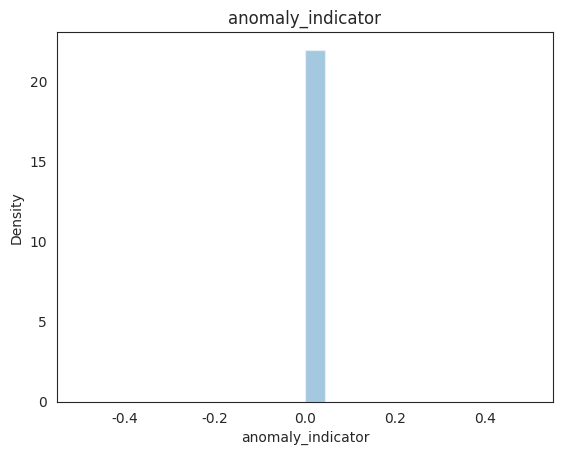

In [17]:
# 정상 데이터의 변수별 분포 확인
for col in df.columns:
    sns.distplot(df_normal.loc[df_normal[col].notnull(), col])
    plt.title(col)
    plt.show()

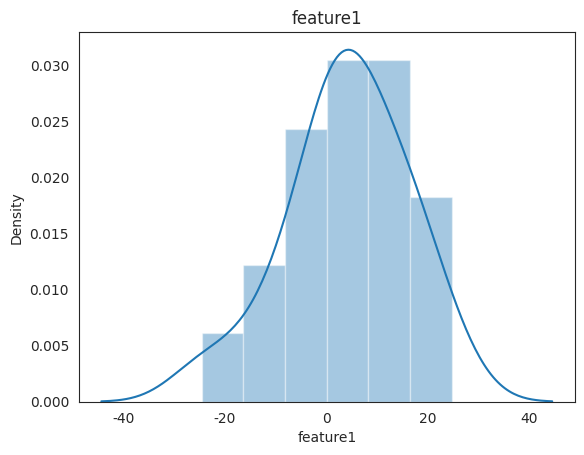

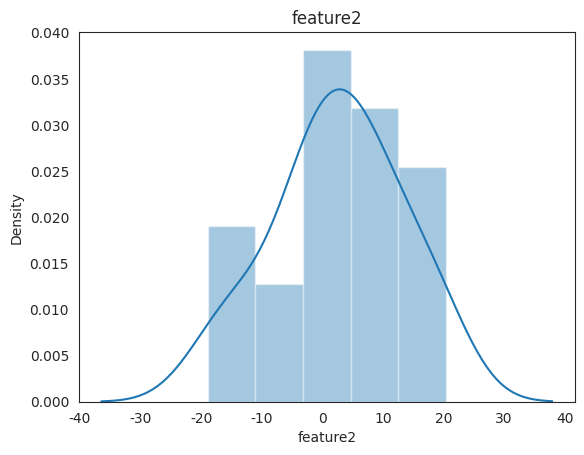

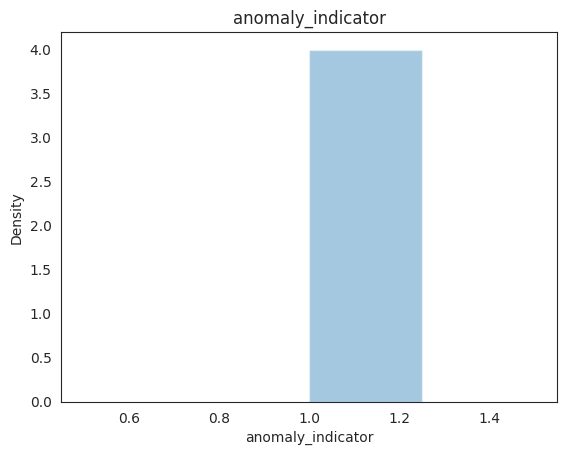

In [18]:
# 이상 데이터의 변수별 분포 확인
for col in df.columns:
    sns.distplot(df_abnormal.loc[df_abnormal[col].notnull(), col])
    plt.title(col)
    plt.show()

### **3-2. 정상 데이터와 이상 데이터의 클래스 수 비교**

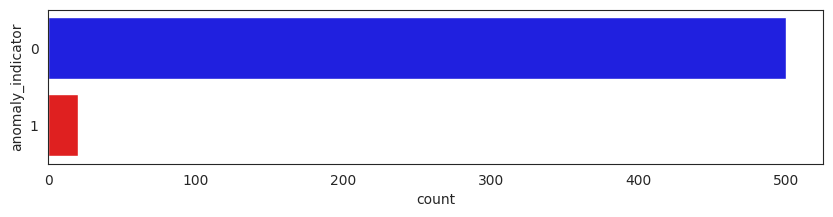

In [19]:
# 정상 데이터와 이상 데이터 클래수 비교
plt.figure(figsize=(10,2))
fig = sns.countplot(y=df['anomaly_indicator'], data=df, palette=["blue", "red"])
plt.show()

----------------------------------------------------------------------------------

## **4. 데이터 전처리**

### **4-1. train, validation 데이터 셋 분할**
- train:test = 0.75 : 0.25  비율로 분할

In [20]:
# train과 test data를 0.75 : 0.25 비율로 나눈다.
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,:-1], df.iloc[:,-1], random_state=3)

----------------------------------------------------------------------------------

## **5. 모델 구축**

### **5-1. 거리기반 이상탐지 모델: K-Nearst-Neighbors**
- 새로운 데이터가 들어왔을 때 k개의 가장 가까이 있는 데이터들과 비교하여 예측하고 분류하는 알고리즘
> 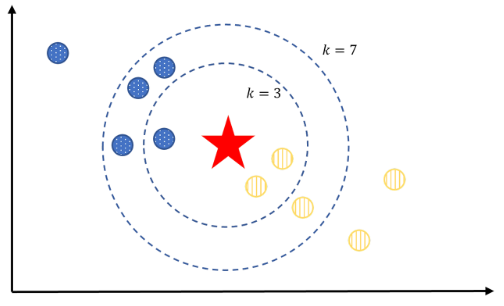
  
- 빨간 별: 새로운 데이터
- k: 임의의 수
    - 데이터셋의 특성과 분류 문제의 성격에 따라 적절한 K값을 선택
        - 데이터셋이 노이즈가 많은 경우 작은 K값
        - 데이터셋이 복잡한 패턴을 가지고 있거나 클래스 간 경계가 모호한 경우 큰 K값

**(1) 모델 생성 및 학습**

**그리드 서치를 활용한 하이퍼파라미터 설정**
- 그리드 서치란?
    - 모델 하이퍼 파라미터에 넣을 수 있는 값들을 순차적으로 입력한뒤에 가장 높은 성능을 보이는 하이퍼 파라미터들을 찾는 탐색 방법
    > 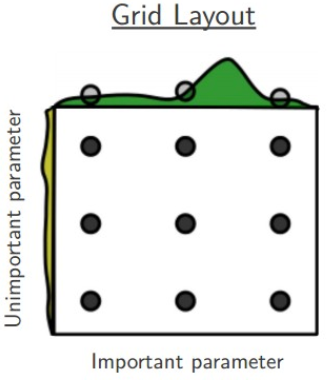

In [21]:
#Hyperparameter
grid_params = { 'n_neighbors' : [5,7,9,11,13,15],
               'weights' : ['uniform','distance'],
               'metric' : ['minkowski','euclidean','manhattan']}

In [22]:
# KNN 모델 생성 후 GridSearchCV 수행
gs = GridSearchCV(KNeighborsClassifier(), grid_params, verbose = 1, cv=3, n_jobs = -1)

In [23]:
# 모델 학습
g_res = gs.fit(X_train, y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


In [24]:
# 최적의 파라미터 조합으로 생성된 모델의 정확도
g_res.best_score_

np.float64(0.9717948717948718)

In [25]:
# 최적의 파라미터 조합
g_res.best_params_

{'metric': 'minkowski', 'n_neighbors': 5, 'weights': 'distance'}

**모델 생성**

In [26]:
#값을 직접 입력
knn = KNeighborsClassifier(n_neighbors = 5, weights = 'distance',algorithm = 'brute',metric = 'minkowski')
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='brute', weights='distance')

In [27]:
# 모델 예측
KNN_train_pred = knn.predict(X_train)
KNN_test_pred = knn.predict(X_test)

In [28]:
#train, test 정확도 확인
print('Training set accuracy: ', metrics.accuracy_score(y_train, KNN_train_pred))
print('Test set accuracy: ',metrics.accuracy_score(y_test, KNN_test_pred))

Training set accuracy:  1.0
Test set accuracy:  0.9615384615384616


Text(0.5, 23.52222222222222, 'Predicted')

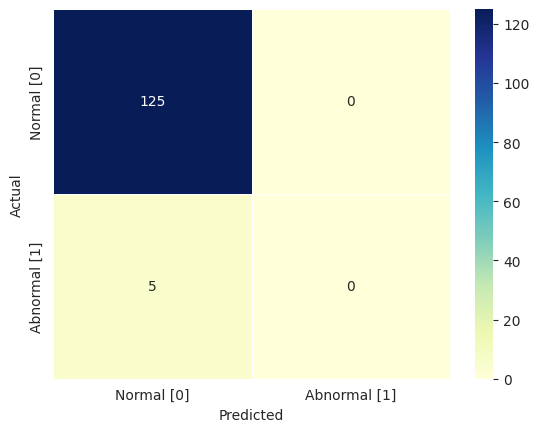

In [29]:
# Confusion matrix 출력 및 모델 성능 평가
con_mat = confusion_matrix(y_test, KNN_test_pred)

sns.heatmap(pd.DataFrame(con_mat, columns = ['Predicted', 'Actual']),
            xticklabels=['Normal [0]', 'Abnormal [1]'], 
            yticklabels=['Normal [0]', 'Abnormal [1]'], 
            annot=True, fmt="d", linewidths=.5, cmap="YlGnBu")
plt.ylabel('Actual')
plt.xlabel('Predicted')

**(2) 이상치 예측 시각화**

**모델 기반으로 이상치 정의**
- 거리가 먼 것이 이상치일 확률 높음

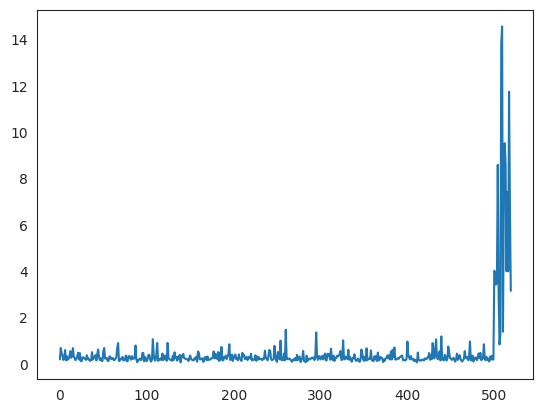

In [30]:
# 모델에서 k-neighbors의 거리 및 인덱스 출력 
distances, indexes = knn.kneighbors(X)
# 각 관측치의 k-거리에 대한 플롯 평균 
plt.plot(distances.mean(axis =1))

In [31]:
# 컷오프 값을 시각적으로 결정 > 2 (이상치가 발생되는 거리의 기준)
outlier_index = np.where(distances.mean(axis = 1) > 2) 
outlier_index

(array([500, 501, 502, 503, 504, 505, 508, 509, 511, 512, 513, 514, 515,
        516, 517, 518, 519]),)

In [32]:
# 이상값 필터링 
outlier_values = df.iloc[outlier_index] 
outlier_values

,feature1,feature2,anomaly_indicator
0,9.620632,-3.117863,1
1,-8.430262,-13.302516,1
2,4.106947,-4.237170,1
3,10.477154,2.790215,1
4,19.651850,-5.468991,1
5,5.414902,7.640531,1
8,24.752814,-13.645993,1
9,-24.553628,10.839973,1
11,-6.822590,-18.910301,1
12,17.383060,15.591251,1


**모델 결과 기반으로 정상, 이상 예측결과 시각화**

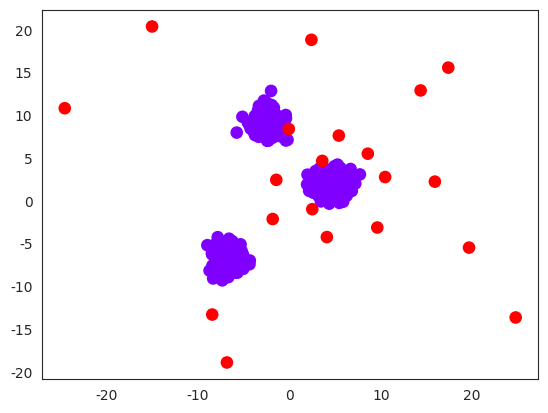

In [33]:
#플롯 데이터
plt.scatter(df['feature1'], df['feature2'], c=df['anomaly_indicator'], cmap='rainbow', s = 65)

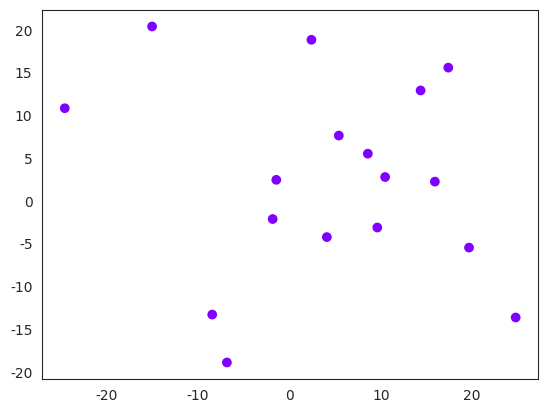

In [62]:
#이상치 그래프
plt.scatter(outlier_values['feature1'], outlier_values['feature2'], c=outlier_values['anomaly_indicator'], cmap='rainbow')

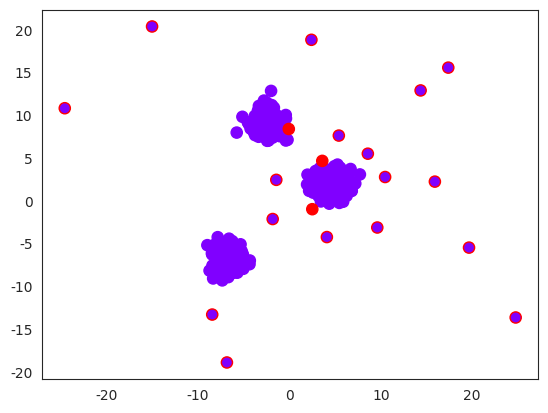

In [63]:
#이상 데이터 시각화
# 플롯 데이터 
plt.scatter(df['feature1'], df['feature2'], c=df['anomaly_indicator'], cmap='rainbow', s = 65)
# 이상값 플롯 
plt.scatter(outlier_values['feature1'], outlier_values['feature2'], c=outlier_values['anomaly_indicator'], cmap='rainbow')

### **5-2. 거리기반 이상탐지 모델: K-Means**
- 각 군집의 평균(mean)을 활용하여 K개의 군집으로 묶는 알고리즘
- 알고리즘 단계
  
  > 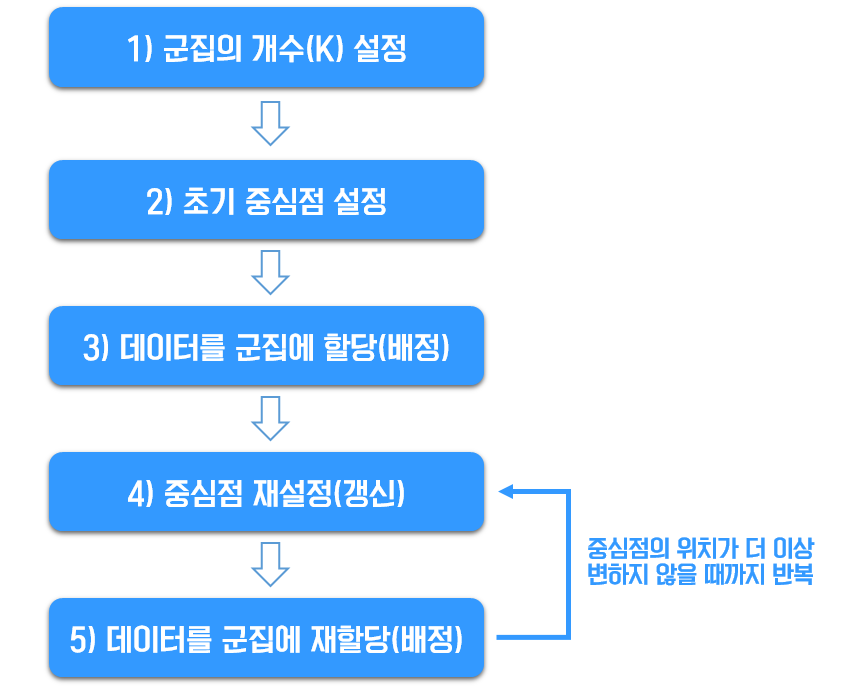
    
    
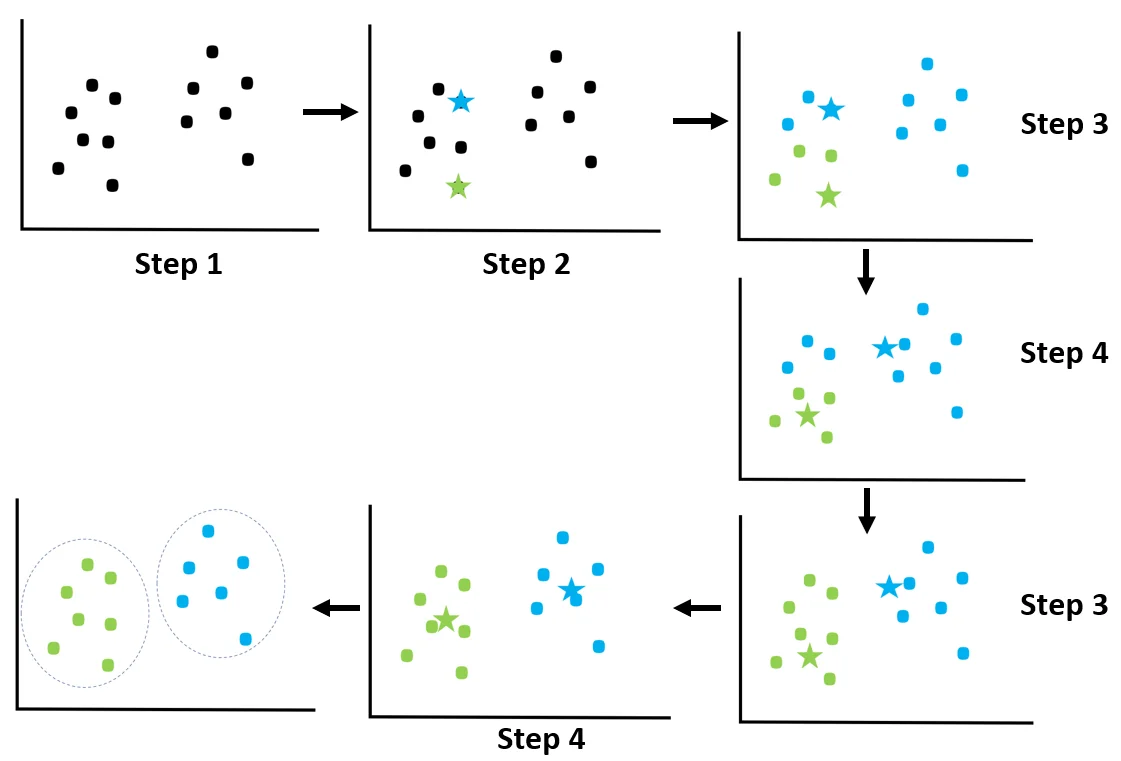

**(1) 모델 생성 및 학습**

**엘보우 포인트를 활용한 클러스터링 개수 정의**
- 클러스터의 중심 간의 거리를 측정한 후 제곱하여 모든 클러스터에 대한 제곱 오차를 합산한 값
- 즉, 각 객체마다 인접한 군집과의 거리를 최소화하는 값을 구하는 것
- 뚝 떨어지는 값을 일반적으로 엘보우 포인트라고 함

In [27]:
ssd = []
for n_clusters in range(2, 11):  # 클러스터 개수를 2에서 10까지 변경
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=200, n_init=10, random_state=0)
    kmeans.fit(X)
    ssd.append(kmeans.inertia_)  # inertia는 SSD 값을 의미

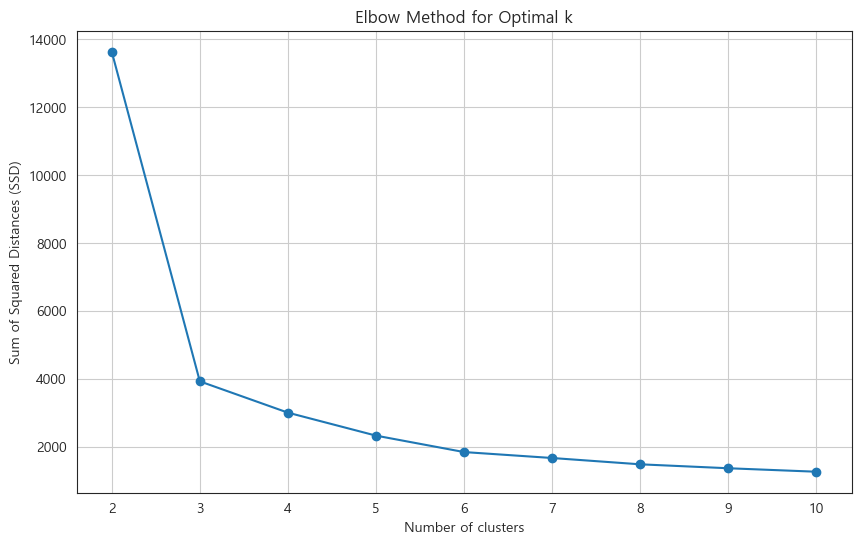

In [28]:
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), ssd, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of Squared Distances (SSD)')
plt.xticks(range(2, 11))
plt.grid()
plt.show()

In [29]:
# 모델 fit
km = KMeans(n_clusters=3)
model = km.fit(X)

**(2) 이상치 예측 시각화**

**모델 결과 기반으로 정상, 이상 예측결과 시각화**

In [30]:
colors=["red","blue","green","orange"]

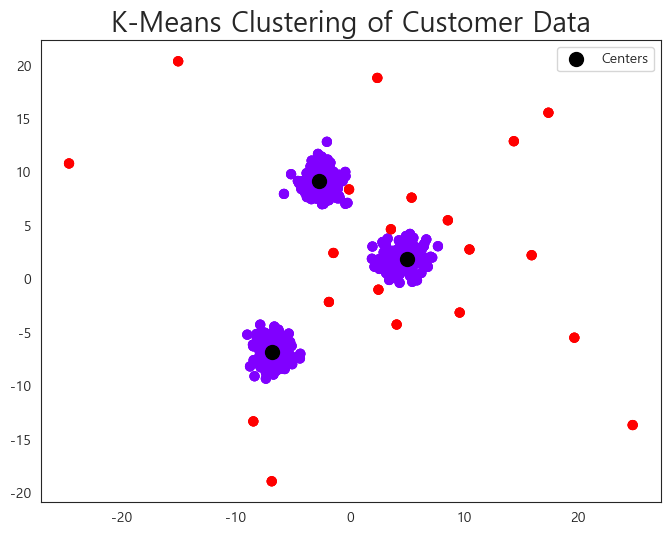

In [31]:
# 시각화
plt.figure(figsize=(8,6))
for i in range(np.max(model.labels_)+1):
    plt.scatter(df['feature1'], df['feature2'], c=df['anomaly_indicator'], cmap='rainbow', s=40)
plt.scatter(model.cluster_centers_[:,0], model.cluster_centers_[:,1], label='Centers', c="black", s=100)
plt.title("K-Means Clustering of Customer Data",size=20)
plt.legend()
plt.show()

In [32]:
# Outlier detection
# 각 센터에서 데이터의 거리를 계산
def distance_from_center(income, score, y, label) :
    center_income = model.cluster_centers_[label, 0]
    center_score = model.cluster_centers_[label, 1]
    dist = np.sqrt((income - center_income) ** 2 + (score - center_score))
    return np.round(dist, 3)

df['label'] = model.labels_
df['distance'] = distance_from_center(df.feature1, df.feature2, df.anomaly_indicator, df.label)

df.head()

,feature1,feature2,anomaly_indicator,label,distance
0,-5.730354,-7.583286,0,0,0.651
1,1.942992,1.918875,0,2,3.084
2,6.829682,1.164871,0,2,1.569
3,-2.901306,7.550771,0,1,NaN
4,5.841093,1.565094,0,2,0.532


In [33]:
#군집에서 멀리 떨어진 데이터 확인->내림차순
outlier_indexs = list(df.sort_values('distance', ascending=False).head(10).index)
outliers = df[df.index.isin(outlier_indexs)]
print(outliers)

     feature1   feature2  anomaly_indicator  label  distance
3   -2.901306   7.550771                  0      1       NaN
4    5.841093   1.565094                  0      2     0.532
8    3.572258   1.830790                  0      2     1.421
9   -7.504446  -6.854019                  0      0     0.683
12  -0.376164   7.062198                  0      1     1.780
13  -1.938307  10.149852                  0      1     1.234
15   5.698303   0.214430                  0      2       NaN
16  -2.581208  10.017819                  0      1     0.928
17  -8.002349  -6.497700                  0      0     1.327
18  -6.797343  -5.814629                  0      0     1.013
3   10.477154   2.790215                  1      2     5.524
4   19.651850  -5.468991                  1      2    14.366
8   24.752814 -13.645993                  1      2    19.323
9  -24.553628  10.839973                  1      1    21.920
12  17.383060  15.591251                  1      2    12.893
13   2.416706  18.846522

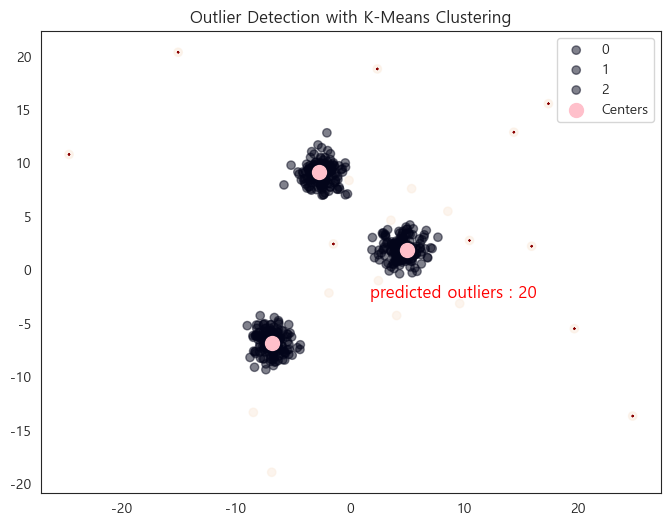

In [34]:
# outlier 시각화
plt.figure(figsize=(8, 6))
for i in range(np.max(model.labels_)+1) :
    plt.scatter(df[model.labels_==i].feature1, df[model.labels_==i].feature2,
               c = df[model.labels_==i].anomaly_indicator, label=i, alpha=0.5)
plt.scatter(outliers.feature1, outliers.feature2, outliers.anomaly_indicator, c='darkred', marker='x')
plt.scatter(model.cluster_centers_[:, 0], model.cluster_centers_[:, 1], 
           label='Centers', c='pink', s=100)
plt.title('Outlier Detection with K-Means Clustering')
plt.legend()

plt.text(1.8, -2.6, f'predicted outliers : {len(outliers)}',fontdict={'color':'red', 'size':12})
plt.show()

### **5-3. 밀도기반 이상탐지 모델: Gaussian Density Estimation**
- 관측 데이터를 바탕으로 데이터의 실제 분포를 하나의 가우시안 분포에 근사하여 확률적으로 분석하는 방법

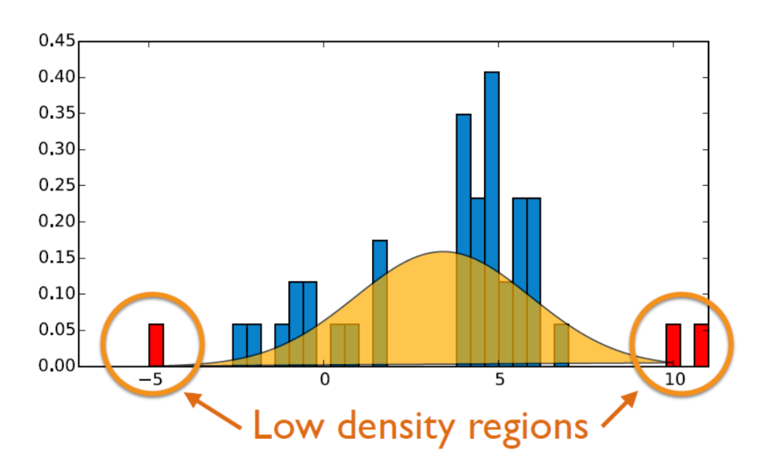

**(1) 모델 생성 및 학습**

In [35]:
# gaussian 분포를 이용해 Outlier를 검출 모델
gde = EllipticEnvelope()
# 모델 fit
gde.fit(X_train)

EllipticEnvelope()

In [36]:
# train data에 대한 예측 값(정상=1, 이상=-1)
GDE_train_pred = gde.predict(X_train) 

# test data에 대한 예측 값(정상=1, 이상=-1)
GDE_test_pred = gde.predict(X_test) 
GDE_test_pred = pd.DataFrame(GDE_test_pred)
# test data에 대한 예측 값(정상=0, 이상=1)로 변환
GDE_test_pred = GDE_test_pred.replace({-1: 1, 1: 0})

Text(0.5, 24.52222222222222, 'Predicted')

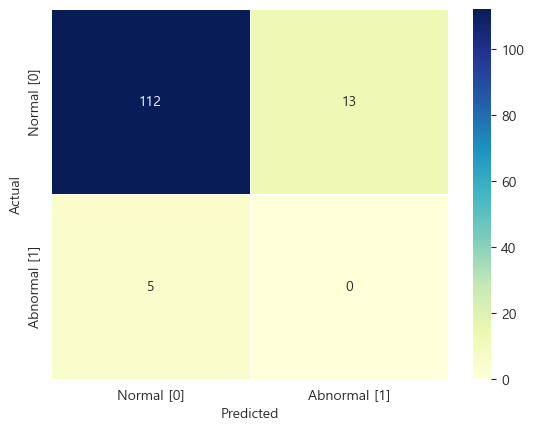

In [37]:
# Confusion matrix 출력 및 모델 성능 평가
con_mat = confusion_matrix(y_test, GDE_test_pred)

sns.heatmap(pd.DataFrame(con_mat, columns = ['Predicted', 'Actual']),
            xticklabels=['Normal [0]', 'Abnormal [1]'], 
            yticklabels=['Normal [0]', 'Abnormal [1]'], 
            annot=True, fmt="d", linewidths=.5, cmap="YlGnBu")
plt.ylabel('Actual')
plt.xlabel('Predicted')

### **5-4. 밀도기반 이상탐지 모델: Mixture of Gaussian**
- 하나가 아니라 다수의 가우시안 분포를 사용하는 gaussian density estimation
  
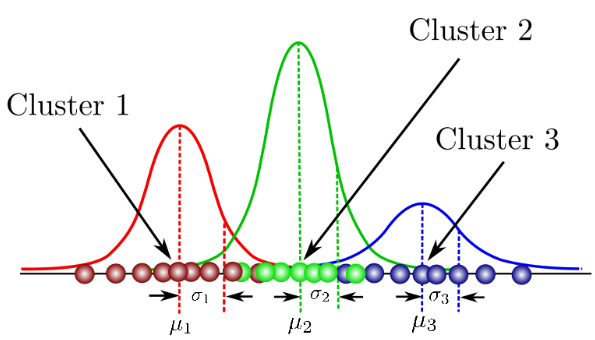

**(1) 모델 생성 및 학습**

In [38]:
#Hyperparameter
lowest_bic = np.inf
bic = []
n_components_range = range(1, 7)
cv_types = ["spherical", "tied", "diag", "full"]
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = GaussianMixture(
            n_components=n_components, covariance_type=cv_type
        )
        gmm.fit(X)
        bic.append(gmm.bic(X))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm
print("covariance : ", best_gmm.covariance_type)
print("n_components : ", best_gmm.n_components)

covariance :  spherical
n_components :  4


In [39]:
# 모델 fit
y_gmm = best_gmm.fit_predict(X)

In [40]:
# test data에 대한 예측 값(정상=0, 이상=-1)
MOG_test_pred = best_gmm.predict(X_test) 
MOG_test_pred = pd.DataFrame(MOG_test_pred)
MOG_test_pred = MOG_test_pred.replace({1:0,2:0,3:0})

Text(0.5, 24.52222222222222, 'Predicted')

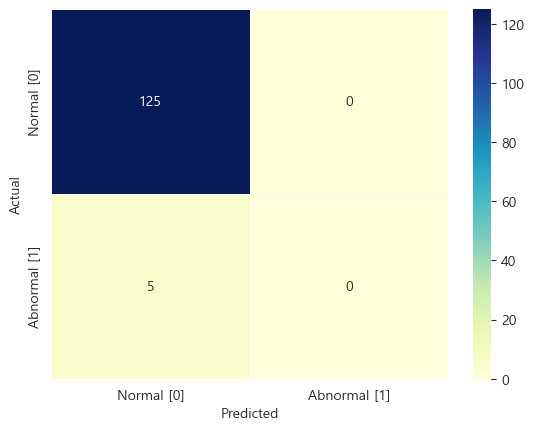

In [41]:
# Confusion matrix 출력 및 모델 성능 평가
con_mat = confusion_matrix(y_test, MOG_test_pred)

sns.heatmap(pd.DataFrame(con_mat, columns = ['Predicted', 'Actual']),
            xticklabels=['Normal [0]', 'Abnormal [1]'], 
            yticklabels=['Normal [0]', 'Abnormal [1]'], 
            annot=True, fmt="d", linewidths=.5, cmap="YlGnBu")
plt.ylabel('Actual')
plt.xlabel('Predicted')

**(2) 이상치 예측 시각화**

**모델 기반으로 이상치 정의**
-  log-likelihood 기반으로 이상치 정의
   -> log-likelihood는 해당 값이 뽑힐 확률을 의미, 따라서 log-likelihood가 낮으면 뽑힐 확률이 적음을 의미하기 때문에 이상치를 의미함

In [42]:
# test 각 샘플의 log-likelihood 계산
score = best_gmm.score_samples(X)

# score column에 저장
df['score'] = score

In [43]:
# threshold 설정(퍼센트) -> 이상치 4% 이상 값
pct_threshold = np.percentile(score, 4)
print(f'The threshold of the score is {pct_threshold:.2f}')

The threshold of the score is -7.76


In [44]:
# 이상치 레이블링
df['anomaly_gmm_pct'] = df['score'].apply(lambda x: 1 if x < pct_threshold else 0)

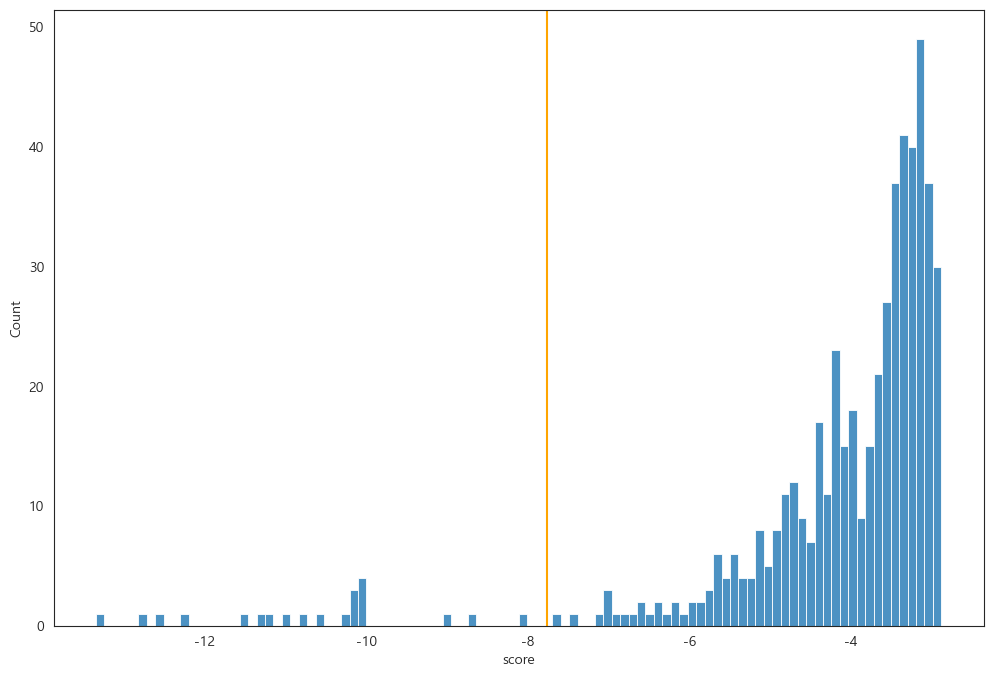

In [45]:
# 그래프 그리기
plt.figure(figsize=(12, 8))
# score 분포
sns.histplot(df['score'], bins=100, alpha=0.8)
# Threshold 값(값 지정)
plt.axvline(x=-7.76, color='orange')
value_threshold = -7.76
# 이상치 레이블링
df['anomaly_gmm_value'] = df['score'].apply(lambda x: 1 if x < value_threshold else 0)

**모델 결과 기반으로 정상, 이상 예측결과 시각화**

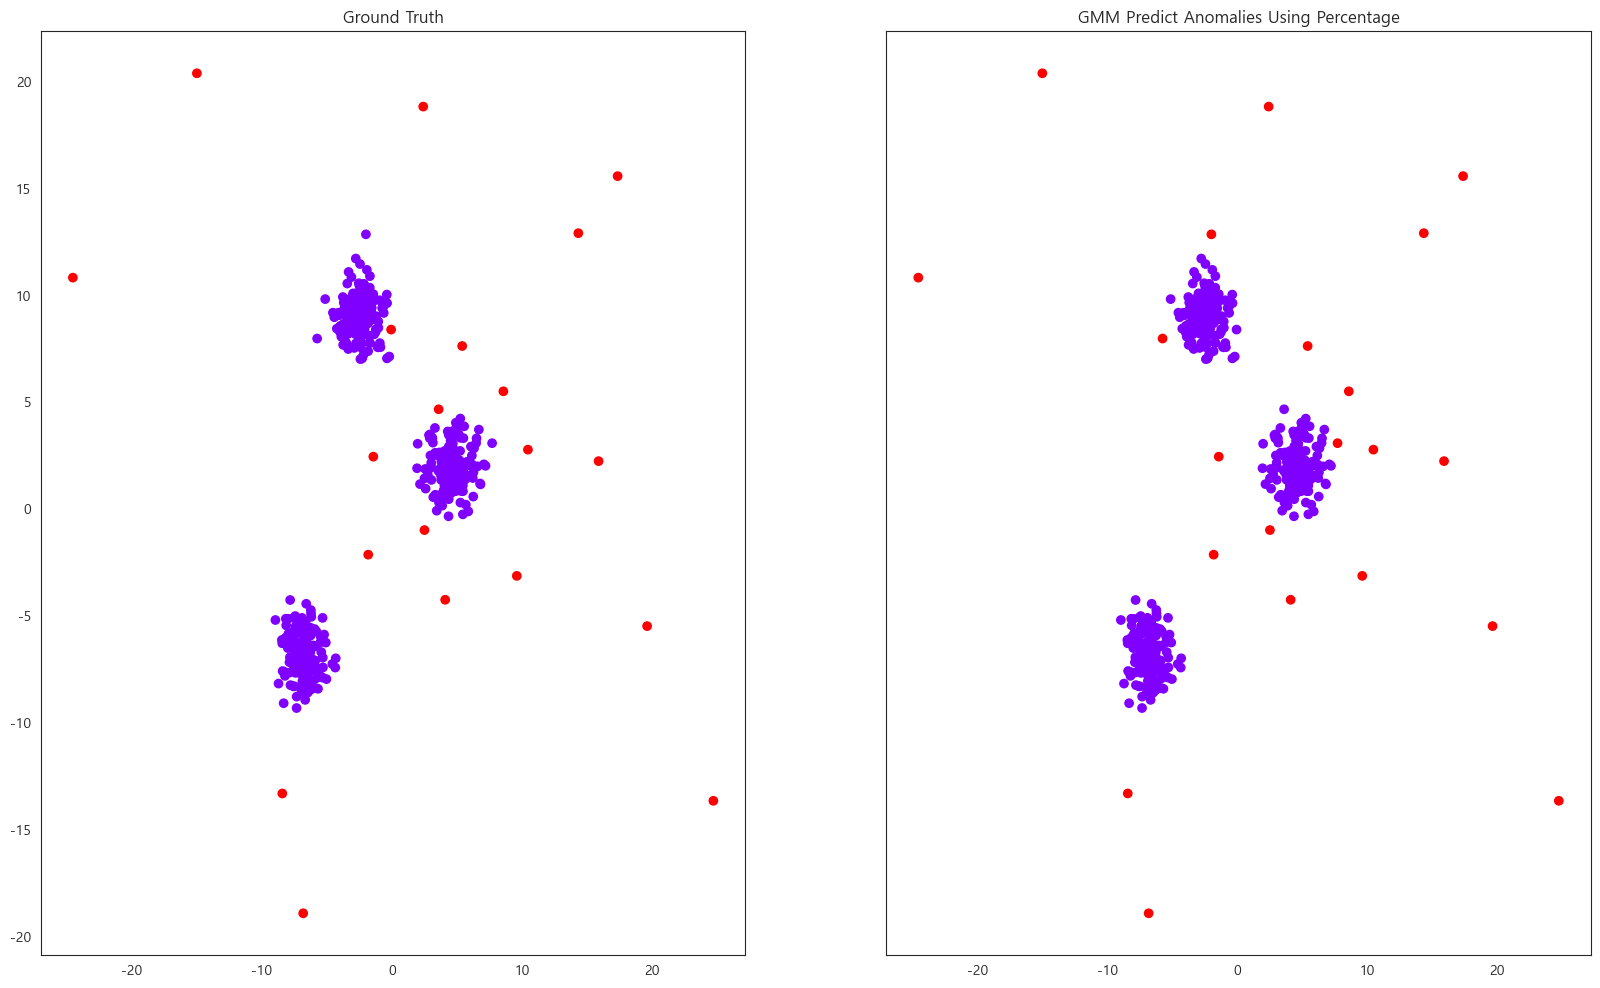

In [46]:
# 예측한 이상치와 실제 값 그래프
fig, (ax0, ax1)=plt.subplots(1,2, sharey=True, figsize=(20,12))
# 실제
ax0.set_title('Ground Truth')
ax0.scatter(df['feature1'], df['feature2'], c=df['anomaly_indicator'], cmap='rainbow')
# 예측
ax1.set_title('GMM Predict Anomalies Using Percentage')
ax1.scatter(df['feature1'], df['feature2'], c=df['anomaly_gmm_pct'], cmap='rainbow')